# Deaths and Hospitals

In [65]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
from matplotlib import dates
import matplotlib.pyplot as plt
import seaborn as sns
import sys; sys.path.append('../')
from src.data_loader.data_loader import *
from src.utils.dates import get_today, lag_date, date2str, str2date, get_format
from src.utils.df_utils import get_date_columns
from src.pandas.align import align_lagged_dates

from scipy.stats import spearmanr

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [66]:
# Time series data
mobility, mobility_date = load_google_mobility()
deaths, deaths_date = load_deaths(join_county_codes=False)
interventions, interventions_date = load_interventions()

# Static data
counties, counties_date = load_counties()

# Processed mobility -> time series
mobility_ts, mobility_ts_date = load_google_mobility_time_series()

m50,_ = load_descartes_m50()

od_mobility = load_od_baseline()

print(f'Mobility Last Updated {mobility_ts_date}')
print(f'Deaths Last Updated {deaths_date}')

Mobility Last Updated 05-08
Deaths Last Updated 05-21


In [68]:
death_dates = get_date_columns(mobility_ts, return_dtimes=False)

In [69]:
def get_onset_date(row, thresh = 5):
    above = row[row > thresh]
    if len(above) == 0:
        return np.nan
    else:
        return above.idxmin()

## Cumulative Deaths
Get cumulative deaths for n_days=14 after the onset at 5 deaths

In [70]:
## Normalize deaths by pop total
deaths_df = deaths[['FIPS']+death_dates]

deaths_df['onset'] = deaths_df[death_dates].apply(lambda row: get_onset_date(row), axis=1)

## New date range
deaths_df = deaths_df.dropna(axis=0, subset=['onset'])

n_days = 28
deaths_df = deaths_df[deaths_df['onset'].apply(lambda d: (str2date(death_dates[-1]) - str2date(d)).days >= n_days)]
# deaths_df = deaths_df[deaths_df['onset'].apply(lambda d: (str2date(death_dates[-1]) - str2date(d)).days >= n_days)]
deaths_df['cum_deaths'] = deaths_df.apply(
    lambda r: sum(r[[d for d in death_dates if 
        str2date(d) >= str2date(r['onset']) and 
        str2date(d) < lag_date(str2date(r['onset']
    ), 
    lag=n_days, backwards=False)]]), axis=1)

In [71]:
def normalize(row, cols, target='cum_deaths'):
    """
    Normalizes target column by column cols
    norm_type : list of len(cols)
     - 1 to multiply target by (i.e. density)
     - -1 to divide target by (i.e. total pop)
    """
    r = row[target]
    for col,norm_type in cols.items():
        if pd.isnull(row[col]):
            r = np.nan
            break
        r *= int(row[col])**(norm_type)

    return r

## Normalize Deaths
Divide the cumulative deaths by the population total and the density

In [7]:
#cum_deaths = pd.concat((deaths['FIPS'], deaths[death_dates].interpolate('linear', axis=1).sum(axis=1)), axis=1)
#cum_deaths.columns = ['FIPS','cum_deaths']
cum_deaths = deaths_df[['FIPS', 'cum_deaths']]
cum_deaths = pd.merge(cum_deaths, counties[['FIPS','Total Hospitals (2019)', 'ICU Beds']], on='FIPS')

m50_dates = get_date_columns(m50, return_dtimes=False)
m50['baseline'] = m50.apply(lambda x: x[m50_dates[:7]].mean(), axis=1)
cum_deaths = pd.merge(cum_deaths, m50[['FIPS', 'baseline']], on='FIPS')
cum_deaths.rename(columns={'baseline':'m50'}, inplace=True)
cum_deaths = pd.merge(cum_deaths, od_mobility, on='FIPS')

confounder_dict = {
    'POP_ESTIMATE_2018' : -1,
    'Density per square mile of land area - Population': -1,
    'Rural-urban_Continuum Code_2013': 0,
    'Total_age65plus': 0,
}
cum_deaths = pd.merge(cum_deaths, counties[['FIPS'] + list(confounder_dict.keys())], on='FIPS')
cum_deaths['normalized_deaths'] = cum_deaths.apply(
    lambda row: normalize(row, confounder_dict), axis=1
    )
for col in ['inter_movement', 'in_movement', 'out_movement']:
    cum_deaths[col] = cum_deaths.apply(lambda row: row[col] / row['POP_ESTIMATE_2018'], axis=1)

In [8]:
log_cols = ['normalized_deaths', 'Total Hospitals (2019)', 'm50', 'ICU Beds', 'inter_movement', 'in_movement', 'out_movement','Density per square mile of land area - Population']
cum_deaths['ICU Beds'] = cum_deaths['ICU Beds'] + 1
cum_deaths[[lc + ' (log)' for lc in log_cols]] = cum_deaths[log_cols].transform('log')

### Mobility within and between counties
Just to see

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b033b69b0>],
      dtype=object)

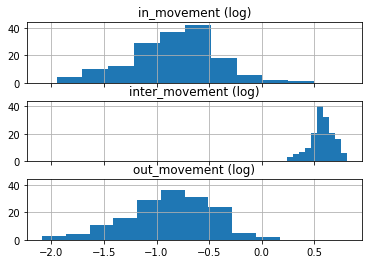

In [9]:
cum_deaths[['inter_movement (log)', 'in_movement (log)', 'out_movement (log)']].hist(sharex=True, sharey=True, layout = (3,1))

Text(0.98, 0.02, '-0.72')

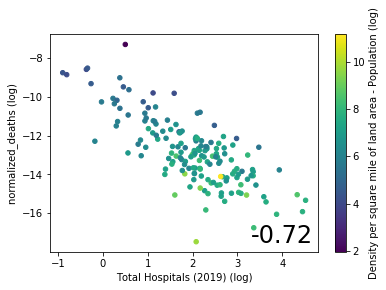

In [10]:
x = 'Total Hospitals (2019) (log)'
y = 'normalized_deaths (log)'
c = 'Density per square mile of land area - Population (log)'
fig, ax = plt.subplots()
cum_deaths.plot.scatter(x=x, y=y,c=c,colormap='viridis', ax=ax)
corr = spearmanr(cum_deaths[x], cum_deaths[y]).correlation
ax.text(0.98,0.02, f'{corr:.2f}',size=24, horizontalalignment='right', verticalalignment='bottom', transform = ax.transAxes)

## The relations between different variables (log-scale)

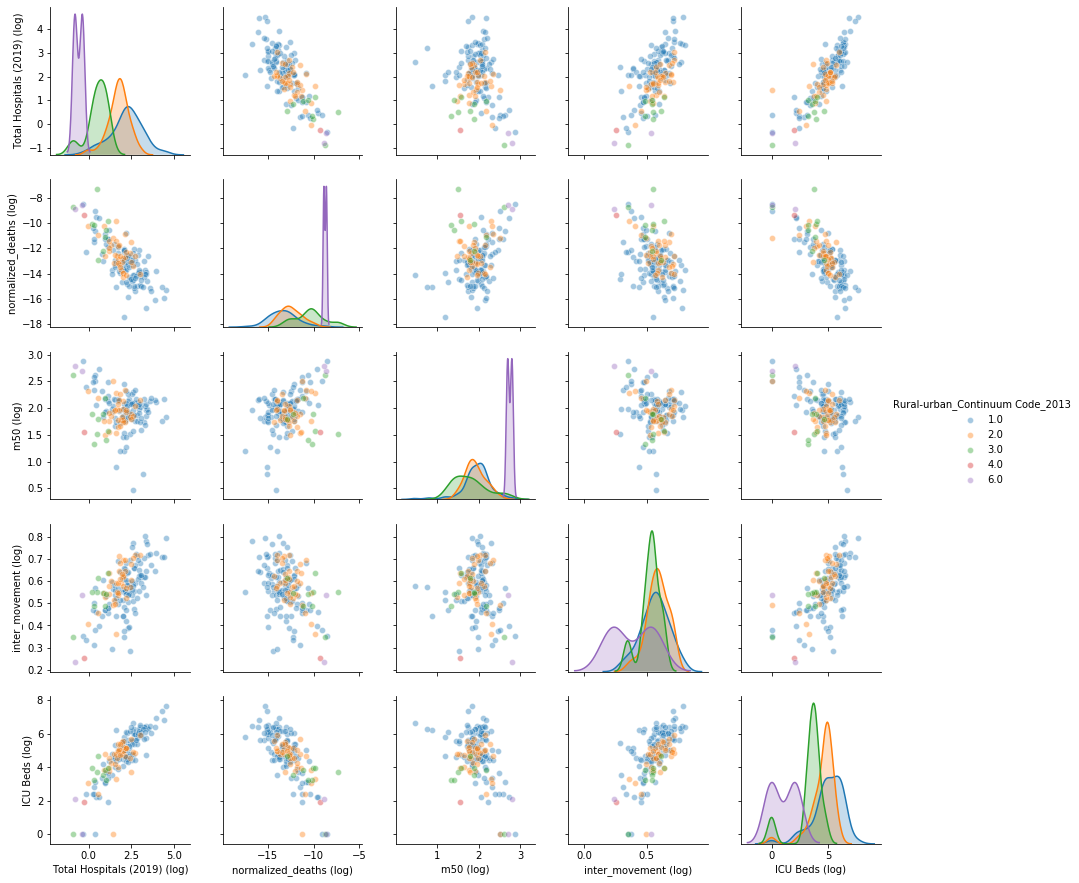

In [11]:
temp = cum_deaths#[cum_deaths['Rural-urban_Continuum Code_2013'].isin([3.0,4.0])]
cols = ['Total Hospitals (2019) (log)',
        'normalized_deaths (log)',
        'm50 (log)',
        'inter_movement (log)',
        'ICU Beds (log)',
]
hue = 'Rural-urban_Continuum Code_2013'
sns.pairplot(temp, vars=cols, hue=hue, plot_kws={'alpha': 0.4})

### Centered
We divide by the mean and standard deviation within each group, as it is clear that the RUCC determines placements that may lead to an effect we don't care about (simpson's paradox)

In [12]:
## Normalize each RUCC region by its mean and std
temp = pd.concat([
    cum_deaths['Rural-urban_Continuum Code_2013'],
    cum_deaths.groupby(
        'Rural-urban_Continuum Code_2013').transform(lambda x: (x - x.mean()) / x.std()
        )
    ], axis=1)
## Plot as before with the prior normalization
cols = ['Total Hospitals (2019) (log)',
        'normalized_deaths (log)',
        'm50 (log)',
        'inter_movement (log)',
        'ICU Beds (log)',
]
hue = 'Rural-urban_Continuum Code_2013'
sns.pairplot(temp, vars=cols, hue=hue, plot_kws={'alpha': 0.4})

ZeroDivisionError: 0.0 cannot be raised to a negative power

### It appears that RUCC 1.0 (cities) have fewer normalized deaths
They have large inter movement, as one might expect in a city. The normalized deaths is striking, but may be a result of selection biase (outbreaks of >= 14 days). We investigate here.

In [79]:
df = deaths[['FIPS'] + death_dates]
df = pd.merge(df, counties[['FIPS', 'POP_ESTIMATE_2018', 'Rural-urban_Continuum Code_2013']], on='FIPS')

In [97]:
df['avg_log_deaths'] = df.apply(
    lambda r: np.sum(r[death_dates]) / np.sum(r[death_dates] > 0) / r['POP_ESTIMATE_2018'], axis=1).fillna(0)
df['avg_log_deaths'] = df['avg_log_deaths'].transform(lambda x: x+0).transform('log')

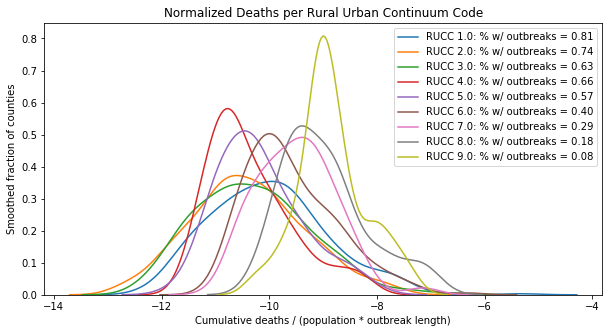

In [113]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
key = 'Rural-urban_Continuum Code_2013'
val = 'avg_log_deaths'
for i in np.unique(df[key]):
    x = df[df[key] == i][val]
    sns.distplot(x, ax=ax, hist=False, kde=True, label=f'RUCC {i}: % w/ outbreaks = {len(x.replace(-np.inf, np.nan).dropna()) / len(x):.2f}')
plt.legend()
plt.xlabel('Cumulative deaths / (population * outbreak length)')
plt.ylabel('Smoothed fraction of counties')
plt.title('Normalized Deaths per Rural Urban Continuum Code')
plt.show()